# Data processing of plume simulation

In [1]:
#####Loading packages and basic functions#####
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
%matplotlib inline

#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json
#Os for file management
import os.path

from decimal import Decimal

RERUN = False #To rerun all computations (False will load from file if they exist)
NCORES_MAX = -2 #Maximal number of cores in use
extension = '.pdf' #fig file extension
DIR  = 'D:/pdm_data/' #On desktop
#DIR  = 'C:/Users/Antoine/Documents/Etudes/Master CSE/PDM/data/' #On laptop
FDIR = '../report/Figures/'
ODIR = DIR + 'Processed_data/' #Output directory

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

def v_to_s(v) :
    if v == 0 :
        return 'Inf'
    else :
        return '%.1E' % v

def v_to_d(v) :
    return '%.2f' % v
    
def v_to_pow(v) :
    if v == 0 :
        return r'$\infty$'
    else :
        power  = int(np.log10(v))
        factor = int(v/10.0**power)
        if factor == 1.0 :
            return r'$10^{'+str(power)+'}$'
        else :
            return str(factor)+r'$\times 10^{'+str(power)+'}$'

def print_keys(dict_) :
    for key in dict_ : print(key)
    return

In [2]:
#####Reference values and ranges for filename generation#####
UREF = 4.6E-06
TREF = 2.92E+01
PECLET    = [0, 1e4, 1e3,1e2,1e1, 1e0]
D_DICT    = {0:'$x_1(t)$',1:'$x_2(t)$',2:'$x_3(t)$',3:'$l(t)$'}
POW_RANGE = [-3, -2, -1, 0, 1, 2]
T_SNAP    = [1.0*10**n_ for n_ in POW_RANGE] + [2.0*10**n_ for n_ in POW_RANGE[:-1]] + [5.0*10**n_ for n_ in POW_RANGE[:-1]]
T_SNAP.sort()
N_SNAP = len(T_SNAP)

FNAMES = {}
for Pe_ in PECLET :
    subdir_ = 'Bentheimer1000/Plumes_mode2/Pe'+v_to_s(Pe_)+'/'
    FNAMES[Pe_] = {t_ : DIR + subdir_ + 'Pe' + v_to_s(Pe_) + '_T'+ v_to_s(t_) + '.txt' for t_ in T_SNAP}

print('Peclet values')
print(PECLET)

Peclet values
[0, 10000.0, 1000.0, 100.0, 10.0, 1.0]


In [3]:
#####Missing data file check, delete name of files that do not exist#####
MISSING = False
missing_keys_dms   = []
missing_keys_tsnaps = []
for Pe_ in FNAMES :
    for tsnap_ in FNAMES[Pe_] : 
        if not os.path.isfile(FNAMES[Pe_][tsnap_]) :
            MISSING = True
            print('Warning :')
            print('\t' + FNAMES[Pe_][tsnap_])
            print('not found')
            missing_keys_dms.append(Pe_)
            missing_keys_tsnaps.append(tsnap_)
for (Pe_,tsnap_) in zip(missing_keys_dms,missing_keys_tsnaps) :
    del FNAMES[Pe_][tsnap_]
if not MISSING :
    print ('All data have been found :)')

All data have been found :)


In [4]:
#####Loading the existing data#####
dataDNS = {}
print('loading file')
for Pe_ in FNAMES :
    print('\tPe = ' + v_to_s(Pe_))
    dataDNS[Pe_] = {}
    print('\t\t(Tsnap, Np) =', end = ' ')
    for tsnap_ in FNAMES[Pe_] :
        dataDNS[Pe_][tsnap_] = np.loadtxt(open(FNAMES[Pe_][tsnap_], 'r').readlines()[:-1])
        N_P=len(dataDNS[Pe_][tsnap_][:,0])
        print('('+v_to_s(tsnap_)+', '+str(N_P+1)+')', end = ', ')
    print('')

loading file
	Pe = Inf
		(Tsnap, Np) = (1.0E-03, 200772), (2.0E-03, 200772), (5.0E-03, 200772), (1.0E-02, 200772), (2.0E-02, 200772), (5.0E-02, 200772), (1.0E-01, 200772), (2.0E-01, 200772), (5.0E-01, 200772), (1.0E+00, 200772), (2.0E+00, 200772), (5.0E+00, 200772), (1.0E+01, 200772), (2.0E+01, 200772), (5.0E+01, 200770), (1.0E+02, 200754), 
	Pe = 1.0E+04
		(Tsnap, Np) = (1.0E-03, 200000), (2.0E-03, 200000), (5.0E-03, 200000), (1.0E-02, 200000), (2.0E-02, 200000), (5.0E-02, 200000), (1.0E-01, 200000), (2.0E-01, 200000), (5.0E-01, 200000), (1.0E+00, 200000), (2.0E+00, 200000), (5.0E+00, 200000), (1.0E+01, 200000), (2.0E+01, 200000), (5.0E+01, 200000), (1.0E+02, 200000), 
	Pe = 1.0E+03
		(Tsnap, Np) = (1.0E-03, 200000), (2.0E-03, 200000), (5.0E-03, 200000), (1.0E-02, 200000), (2.0E-02, 200000), (5.0E-02, 200000), (1.0E-01, 200000), (2.0E-01, 200000), (5.0E-01, 200000), (1.0E+00, 200000), (2.0E+00, 200000), (5.0E+00, 200000), (1.0E+01, 200000), (2.0E+01, 200000), (5.0E+01, 200000), (1.0E+

In [5]:
#####Auxiliary functions to compute PDF and return mean and std#####
def Extract_pdf(data_, nbins = 500, returnNP = False, dst = True) :
    np_  = len(data_)
    pdf_ = np.histogram(data_, bins = nbins, density = dst);
    pdf_ = np.array([pdf_[1][0:-1], pdf_[0]])
    if returnNP :
        return pdf_, np_
    else :
        return pdf_

def Return_mean(pdf_) :
    x = pdf_[0]; y = pdf_[1];
    return np.sum(x*y)/np.sum(y)

def Return_std(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu = Return_mean(pdf_)
    std  = np.sqrt(np.sum([(x_ - mu)**2*y_ for (x_,y_) in zip(x,y)])/np.sum(y))
    return std

### DNS PDF for various directions, Pe and times

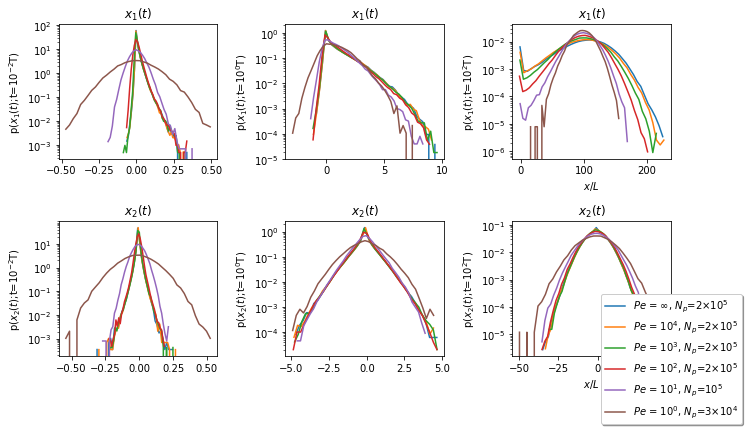

In [6]:
T_PLOTS      = [1.0E-02, 1.0E0, 1.0E+02]
D_VALUES     = [0,1]
PECLET_PLOTS = [0.0, 10000.0, 100.0, 1.0]
fig, axs = plt.subplots(len(D_VALUES),len(T_PLOTS), figsize = (3.5*len(T_PLOTS),3.0*len(D_VALUES)))
l_  = 0
nbins_ = 40
plot_hist = False
for d_ in D_VALUES :#range(4) :
    dname_ = D_DICT[d_]
    c_ = 0
    for t_ in T_PLOTS :
        if len(D_VALUES) == 1 : ax = axs[l_]
        elif len(T_PLOTS) == 1 : ax = axs[c_]
        else : ax = axs[l_,c_]
        ci_ = 0
        for Pe_ in PECLET :
            if t_ in dataDNS[Pe_] :
                [x_, y_], N_P_  = Extract_pdf(dataDNS[Pe_][t_][:,d_], nbins_, True)
                ax.semilogy(x_, y_, color = color_cycle[ci_], label = '$Pe$ = '+v_to_pow(Pe_) + ', $N_p$='+v_to_pow(N_P_+1));
                ci_ += 1
            ax.set_ylabel(r'p('+dname_+';t='+v_to_pow(t_)+'T)')
        ax.set_title(dname_)
        c_ += 1
    l_ += 1
    ax.set_xlabel('$x/L$')
ax.legend(loc='upper center', bbox_to_anchor=(1.0, 0.5), shadow=True, ncol=1)
plt.tight_layout()
plt.savefig(FDIR+'plume_displacement_pdf'+extension)

### DNS Scatter Plots 

##### 3D cuts

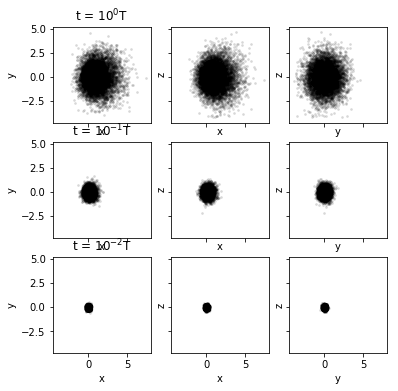

In [11]:
#Scatter plot
Pe_     = 1.0
Npoints = 10000
area = np.pi

# Plot
fig, axs = plt.subplots(3,3,figsize=(6,6), sharex = True, sharey = True)
li_ = 0
for t_ in [1e0, 1e-1, 1e-2] :
    x = dataDNS[Pe_][t_][:Npoints,0]
    y = dataDNS[Pe_][t_][:Npoints,1]
    z = dataDNS[Pe_][t_][:Npoints,2]
    ax = axs[li_, 0]
    ax.scatter(x, y, s=area, color='k', alpha=0.1)
    ax.set_title('t = '+v_to_pow(t_)+'T');
    ax.set_xlabel('x');
    ax.set_ylabel('y');
    ax = axs[li_, 1]
    ax.scatter(x, z, s=area, color='k', alpha=0.1)
    ax.set_xlabel('x');
    ax.set_ylabel('z');
    ax = axs[li_, 2]
    ax.scatter(y, z, s=area, color='k', alpha=0.1)
    ax.set_xlabel('y');
    ax.set_ylabel('z');
    li_ += 1

### X diffusion

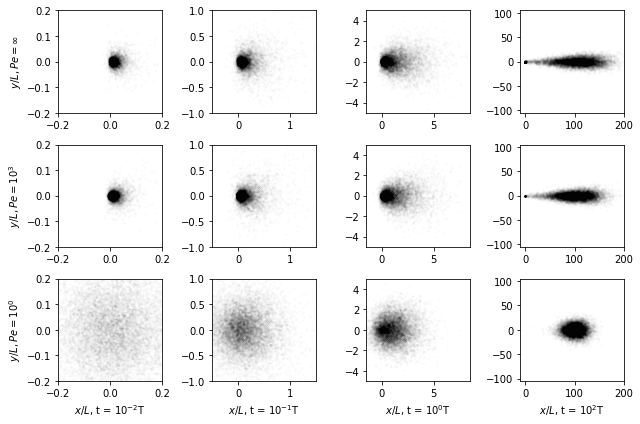

In [12]:
#Scatter plot
Pe_     = 0.0
Npoints = 10000
area = np.pi

# Plot
T_PLOTS  = [0.01, 0.1, 1.0, 100.0]
PE_PLOTS = [0.0, 1000.0, 1.0]
fig, axs = plt.subplots(len(PE_PLOTS),len(T_PLOTS),figsize=(9,6))
li_ = 0
xrange = [[-.2, .2], [-.5, 1.5] , [-1.5, 8.5], [-10.0, 200]]
xlim_ = {tt_ : xxlim_ for (tt_,xxlim_) in zip(T_PLOTS,xrange)}
yrange = [[-.2, .2], [-1.0, 1.0], [-5, 5]   , [-105, 105]]
ylim_ = {tt_ : yylim_ for (tt_,yylim_) in zip(T_PLOTS,yrange)}

for Pe_ in  PE_PLOTS :
    ci_ = 0
    for t_ in T_PLOTS :
        x = dataDNS[Pe_][t_][:Npoints,0]
        y = dataDNS[Pe_][t_][:Npoints,1]
        ax = axs[li_, ci_]
        ax.scatter(x, y, s=area, color=(0.01,0.01,0.01), alpha = 0.01)
        if li_ == len(PE_PLOTS)-1 : ax.set_xlabel(r'$x/L$, ' + 't = '+v_to_pow(t_)+'T');
        if ci_ == 0 : ax.set_ylabel(r'$y/L, Pe = $'+v_to_pow(Pe_));
        ax.set_xlim(xlim_[t_])
        ax.set_ylim(ylim_[t_])
        ci_ += 1
    li_ += 1
plt.tight_layout()
plt.savefig(FDIR+'plume_scatter'+extension)

#### Finding $D_L$ and $D_T$

In [7]:
DL = {}
DT = {}
dts = []
for Pe_ in PECLET :
    DL[Pe_] = []
    DT[Pe_] = []
    for t_ in T_SNAP :
        DL[Pe_].append(np.mean(dataDNS[Pe_][t_][:,0]**2)/(t_))
        DT[Pe_].append(np.mean(dataDNS[Pe_][t_][:,1]**2+dataDNS[Pe_][t_][:,2]**2)/(t_))

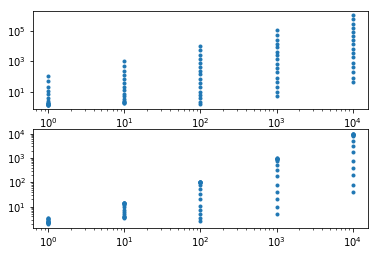

In [8]:
plt.subplot(211)
for i in range(len(T_SNAP)) : plt.loglog(PECLET[1:],[DL[Pe_][i]*Pe_ for Pe_ in PECLET[1:]],'.', color = color_cycle[0])
plt.subplot(212)
for i in range(len(T_SNAP)) : plt.loglog(PECLET,[DT[Pe_][i]*Pe_ for Pe_ in PECLET],'.', color = color_cycle[0])

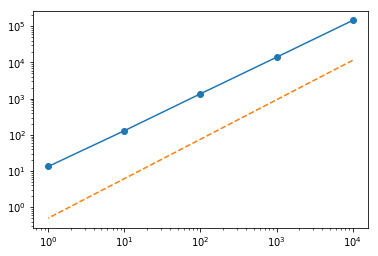

In [9]:
a_L = 0.5; b_L = 1.09
plt.loglog(PECLET[1:],[np.mean(DL[Pe_][:])*Pe_ for Pe_ in PECLET[1:]],'o-');
plt.loglog(PECLET[1:],[a_L*Pe_**b_L for Pe_ in PECLET[1:]],'--');

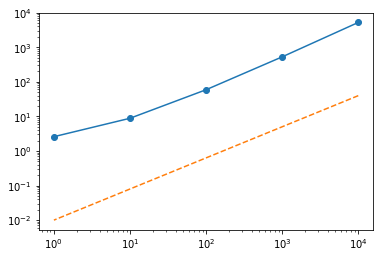

In [10]:
a_T = 0.01; b_T = 0.9
plt.loglog(PECLET[1:],[np.mean(DT[Pe_][:])*Pe_ for Pe_ in PECLET[1:]],'o-');
plt.loglog(PECLET[1:],[a_T*Pe_**b_T for Pe_ in PECLET[1:]],'--');

#### Continuous interpolation using Gaussian 2D univariate

In [11]:
def Gaussian_2D_Univariate (x, y, mux=0, muy=0, sigma=1) :
    x_ = (x - mux*np.ones(np.shape(x[1])))/np.sqrt(sigma)
    y_ = (y - muy*np.ones(np.shape(y[1])))/np.sqrt(sigma)
    
    A = 1.0/(2.0*np.pi*sigma)
    
    B = np.exp(-0.5*x_*x_) * np.exp(-0.5*y_*y_)
    return A*B

def Gaussian_Density_Estimation (X, Y, xlim, ylim, Nres, Blur) :
    Np   = len(X)
    x    = np.linspace(xlim[0], xlim[1], Nres)
    y    = np.linspace(ylim[0], ylim[1], Nres)

    mesh = np.meshgrid(x,y)
    G    = np.zeros(np.shape(mesh[0]))
    
    for i in range(Np) :
        G += Gaussian_2D_Univariate (mesh[0], mesh[1], X[i], Y[i], Blur)
        
    return mesh, G

In [12]:
T_PLOTS  = [0.01, 1.0, 100.0]
PE_PLOTS = [0.0, 10000.0, 100.0, 1.0]
xrange = [[-.4, .4], [-2.0, 9.0], [-10.0, 200]]
xlim_  = {tt_ : xxlim_ for (tt_,xxlim_) in zip(T_PLOTS,xrange)}
yrange = [[-.4, .4], [-5.5, 5.5]   , [-105, 105]]
ylim_  = {tt_ : yylim_ for (tt_,yylim_) in zip(T_PLOTS,yrange)}
Nres = 50
GG = {}
II = {}
NN = {}

In [13]:
for Pe_ in PE_PLOTS :
    GG[Pe_] = {}
    II[Pe_] = {}
    NN[Pe_] = {}
    for t_ in T_PLOTS :
        Np      = len(dataDNS[Pe_][t_])
        xlim    = xlim_[t_]
        ylim    = ylim_[t_] 
        Blur    = ((xlim[1]-xlim[0])/Nres)**2
        [X,Y,Z] = [dataDNS[Pe_][t_][:Np,0], dataDNS[Pe_][t_][:Np,1], dataDNS[Pe_][t_][:Np,2]]
        GG[Pe_][t_] = Gaussian_Density_Estimation (X, Y, xlim, ylim, Nres, Blur)
        dx  = GG[Pe_][t_][0][0][1,1] - GG[Pe_][t_][0][0][0,0]
        II[Pe_][t_] = np.sum(np.sum(GG[Pe_][t_][1]*dx)*dx)
        NN[Pe_][t_] = Np
        print('Discrete integral : ' + str(II[Pe_][t_]))

Discrete integral : 200770.9983678981
Discrete integral : 200767.32747449804
Discrete integral : 200601.5320225478
Discrete integral : 199998.99847506592
Discrete integral : 199995.40011045185
Discrete integral : 199917.0966101986
Discrete integral : 199998.9999020662
Discrete integral : 199997.88339791802
Discrete integral : 199996.86967074667
Discrete integral : 35261.96412254727
Discrete integral : 35362.02331242987
Discrete integral : 35364.00000381967


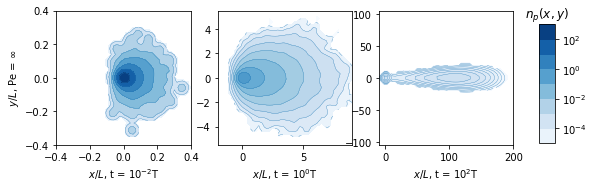

In [14]:
epsilon = 1e-5
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
# Plot
fig, axs = plt.subplots(1,len(T_PLOTS),figsize=(9,3))
ci_ = 0; li_ = 0 
Pe_ = 0
for t_ in T_PLOTS :
    xx_ = GG[Pe_][t_][0][0]
    yy_ = GG[Pe_][t_][0][1]
    zz_ = np.array([G_/NN[Pe_][t_] for G_ in GG[Pe_][t_][1]])
    mask = (zz_ < epsilon)
    zz_ = np.log10([G_/NN[Pe_][t_] for G_ in GG[Pe_][t_][1]])
    zz_ = np.ma.array(zz_, mask=mask)
    ax = axs[ci_]
    cs = ax.contourf(xx_, yy_, zz_,8, cmap = plt.get_cmap('Blues'), vmin = -5, vmax = 3) 
    ax.contour(xx_, yy_, zz_,8,colors = color_cycle[0], linestyles='solid', linewidths = 0.3) 
    x = dataDNS[Pe_][t_][:100,0]
    y = dataDNS[Pe_][t_][:100,1]
    ax.set_xlabel(r'$x/L$, t = '+v_to_pow(t_)+'T');
    if ci_ == 0 : ax.set_ylabel(r'$y/L$, Pe = '+v_to_pow(Pe_));
    ax.set_xlim(xlim_[t_])
    ax.set_ylim(ylim_[t_])
    ax.set(aspect='equal')
    if (ci_,li_) == (0,0) : 
        im = cs
        cbar_ax = ax
    ci_ += 1
fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.87, 0.2, 0.025, 0.55])
V_ = [-4,-2,-0,2]
cbar = fig.colorbar(im, cax=cbar_ax,ticks= V_)
cbar.ax.set_yticklabels([v_to_pow(10**v_) for v_ in V_])  # vertically oriented colorbar
cbar.ax.set_title(r'$n_p(x,y)$', rotation=0)

plt.savefig(FDIR+'plume_density_PeInf.pdf')
plt.savefig(FDIR+'plume_density_PeInf.png')

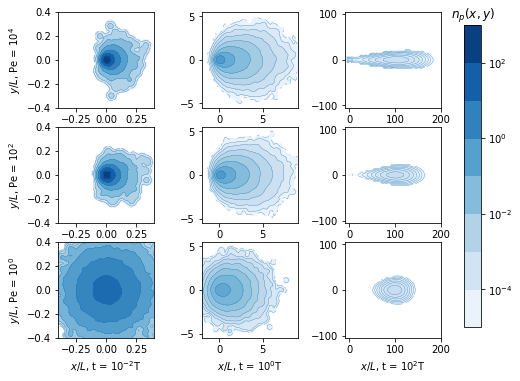

In [90]:
epsilon = 1e-5
Npoints = 1000
# Plot
fig, axs = plt.subplots(len(PE_PLOTS[1:]),len(T_PLOTS),figsize=(8,6))
li_ = 0
#cvmax  = [2.8e8, 2.4e5, 1.2e2]
#cvlim  = {tt_ : cvm_ for (tt_,cvm_) in zip(T_PLOTS,cvmax)}
for Pe_ in  PE_PLOTS[1:] :
    ci_ = 0
    for t_ in T_PLOTS :
        xx_ = GG[Pe_][t_][0][0]
        yy_ = GG[Pe_][t_][0][1]
        zz_ = np.array([G_/NN[Pe_][t_] for G_ in GG[Pe_][t_][1]])
        mask = (zz_ < epsilon)
        zz_ = np.log10([G_/NN[Pe_][t_] for G_ in GG[Pe_][t_][1]])
        zz_ = np.ma.array(zz_, mask=mask)
        #zz_ = [G_/NN[Pe_][t_] for G_ in GG[Pe_][t_][1]]
        ax = axs[li_, ci_]
        cs = ax.contourf(xx_, yy_, zz_,8, cmap = plt.get_cmap('Blues'), vmin = -5, vmax = 3) 
        ax.contour(xx_, yy_, zz_,8,colors = color_cycle[0], linestyles='solid', linewidths = 0.3) 
        x = dataDNS[Pe_][t_][:100,0]
        y = dataDNS[Pe_][t_][:100,1]
        ax = axs[li_, ci_]

        if li_ == len(PE_PLOTS)-2 : ax.set_xlabel(r'$x/L$, t = '+v_to_pow(t_)+'T');
        if ci_ == 0 : ax.set_ylabel(r'$y/L$, Pe = '+v_to_pow(Pe_));
        ax.set_xlim(xlim_[t_])
        ax.set_ylim(ylim_[t_])
        ax.set(aspect='equal')
        if (ci_,li_) == (0,0) : 
            im = cs
            cbar_ax = ax
        #cb = plt.colorbar(cs, ax=ax)
        #cb.formatter.set_powerlimits((0, 0))
        #cb.update_ticks()
        #cb.ax.set_yticklabels(['0', v_to_pow(0.25*Gmax),v_to_pow(0.5*Gmax),v_to_pow(0.75*Gmax), v_to_pow(1.0*Gmax)])  # vertically oriented colorbar
        ci_ += 1
    li_ += 1
    
fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
V_ = [-4,-2,-0,2]
cbar = fig.colorbar(im, cax=cbar_ax,ticks= V_)
cbar.ax.set_yticklabels([v_to_pow(10**v_) for v_ in V_])  # vertically oriented colorbar
cbar.ax.set_title(r'$n_p(x,y)$', rotation=0)

plt.savefig(FDIR+'plume_density.pdf')
plt.savefig(FDIR+'plume_density.png')

In [16]:
PP = {}
for Pe_ in PE_PLOTS :
    PP[Pe_] = {}
    for t_ in T_PLOTS :
        dx = GG[Pe_][t_][0][0][1,1] - GG[Pe_][t_][0][0][0,0]
        PP[Pe_][t_] = GG[Pe_][t_][1]*dx*dx/NN[Pe_][t_]
        print('S = ' + str(np.sum(np.sum(PP[Pe_][t_]*dx*dx))))

S = 0.00026655559966569267
S = 0.05039474662828744
S = 18.353488790244825
S = 0.0002665555998001601
S = 0.05039476137273372
S = 18.359825161286903
S = 0.0002665556017020443
S = 0.05039538711052174
S = 18.367151295314848
S = 0.00026566631058462525
S = 0.050370062276246956
S = 18.367346940759365


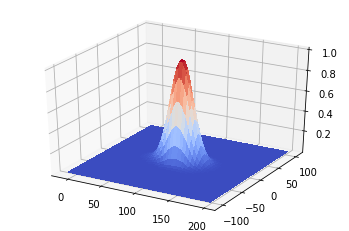

In [17]:
from mpl_toolkits.mplot3d import Axes3D 
xx_ = GG[Pe_][t_][0][0]
yy_ = GG[Pe_][t_][0][1]
zz_ = GG[Pe_][t_][1]/np.max(GG[Pe_][t_][1])
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx_, yy_, zz_, cmap='coolwarm',
                       linewidth=0, antialiased=False)

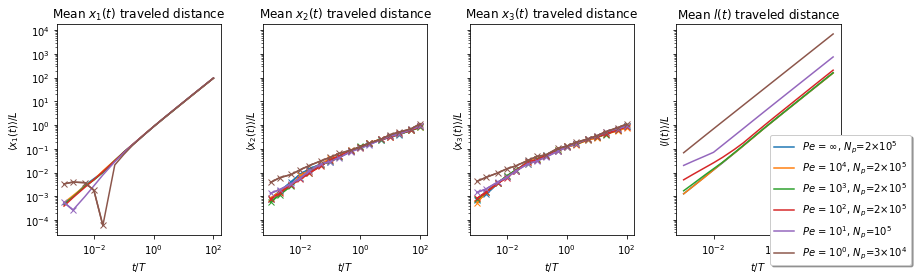

In [18]:
#####Plot of mean position for $x_1$ and total traveled distance#####
fig, axs = plt.subplots(1,4, figsize = (12,4), sharey = True)
D_VALUES = [0,1,2,3]
d_ = 0
nbins_ = 40
c_ = 0
for d_ in D_VALUES :
    l_ = 0
    ax = axs[c_]
    for i in range(len(PECLET)) :
            Pe_ = PECLET[i]; 
            clr = color_cycle[i]
            TIME_ = np.array([tt_ for tt_ in dataDNS[Pe_]])
            PDF_ = [Extract_pdf(dataDNS[Pe_][t_][:,d_], nbins_) for t_ in dataDNS[Pe_]]
            MEAN_ = [Return_mean(pdf_) for pdf_ in PDF_]    
            N_P_ = len(dataDNS[Pe_][t_][:,0])+1
            ax.loglog(TIME_, np.abs(MEAN_), color = clr, label = '$Pe$ = '+v_to_pow(Pe_) + ', $N_p$='+v_to_pow(N_P_))
            #Marking negative values :
            ax.loglog([TIME_[i] for i in range(len(TIME_)) if MEAN_[i]<0], [-MEAN_[i] for i in range(len(MEAN_)) if MEAN_[i]<0], color = clr, marker = 'x')
    ax.set_xlabel('$t/T$')
    ax.set_ylabel(r'$\langle$'+D_DICT[d_]+r'$\rangle/L$')
    ax.set_title('Mean '+D_DICT[d_]+' traveled distance')
    c_ += 1
plt.tight_layout()
ax.legend(loc='upper center', bbox_to_anchor=(1.0, 0.5), shadow=True, ncol=1)
plt.savefig(FDIR+'plume_mean_x1_l'+extension)

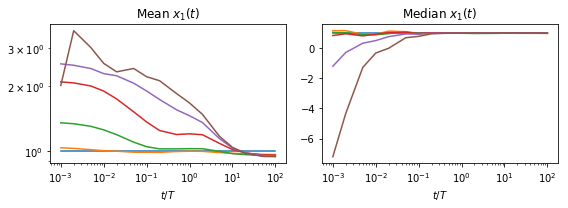

In [19]:
#####Plot of mean position for $x_1$ and total traveled distance#####
fig, axs = plt.subplots(1,2, figsize = (8,3), sharey = False)
D_VALUES = [0]
d_ = 0
nbins_ = 40
c_ = 0
MEDIAN_INF = np.array([np.median(dataDNS[0][t_][:,d_]) for t_ in dataDNS[0]])
PDF_ = [Extract_pdf(dataDNS[0][t_][:,d_], nbins_) for t_ in dataDNS[0]]
MEAN_INF = np.array([Return_mean(pdf_) for pdf_ in PDF_])
for d_ in D_VALUES :
    l_ = 0
    for i in range(len(PECLET)) :
            Pe_ = PECLET[i]; 
            clr = color_cycle[i]
            TIME_ = np.array([tt_ for tt_ in dataDNS[Pe_]])
            
            PDF_   = [Extract_pdf(dataDNS[Pe_][t_][:,d_], nbins_) for t_ in dataDNS[Pe_]]
            MEAN_  = np.array([Return_mean(pdf_) for pdf_ in PDF_])
            MEAN_ /= MEAN_INF
            
            MEDIAN_  = np.array([np.median(dataDNS[Pe_][t_][:,d_]) for t_ in dataDNS[Pe_]])
            MEDIAN_ /= MEDIAN_INF
            
            N_P_ = len(dataDNS[Pe_][t_][:,0])+1
            axs[0].plot(TIME_, MEDIAN_, color = clr, label = '$Pe$ = '+v_to_pow(Pe_) + ', $N_p$='+v_to_pow(N_P_))
            axs[1].plot(TIME_, MEAN_, color = clr, label = '$Pe$ = '+v_to_pow(Pe_) + ', $N_p$='+v_to_pow(N_P_))
            #Marking negative values :
            #ax.plot([TIME_[i] for i in range(len(TIME_)) if MEDIAN_[i]<0], [-MEDIAN_[i] for i in range(len(MEDIAN_)) if MEDIAN_[i]<0], color = clr, marker = 'x')
    axs[0].set_xlabel('$t/T$')
    axs[0].set_title('Mean '+D_DICT[d_])
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    axs[1].set_xlabel('$t/T$')
    axs[1].set_title('Median '+D_DICT[d_])
    axs[1].set_xscale('log')
    c_ += 1
plt.tight_layout()
ax.legend(loc='upper center', bbox_to_anchor=(1.0, 0.5), shadow=True, ncol=1)
plt.savefig(FDIR+'plume_mean_x1_l'+extension)

The totaled travel length $l(t)$ increases with $D_m$ but not the directional traveled distances.

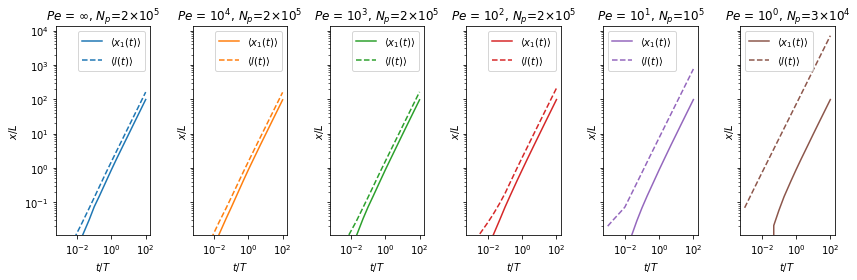

In [20]:
#####Plot of mean position for $x_1$ and total traveled distance#####
fig, axs = plt.subplots(1,len(PECLET), figsize = (12,4), sharey = True)
D_VALUES = [0,3]
d_ = 0
nbins_ = 40
c_ = 0
for i in range(len(PECLET)) :
    l_ = 0
    ax = axs[c_]
    for (d_,lst_) in zip(D_VALUES,['-','--']) :
            Pe_ = PECLET[i]; clr = color_cycle[i]
            TIME_ = np.array([tt_ for tt_ in dataDNS[Pe_]])
            PDF_ = [Extract_pdf(dataDNS[Pe_][t_][:,d_], nbins_) for t_ in dataDNS[Pe_]]
            MEAN_ = [Return_mean(pdf_) for pdf_ in PDF_]    
            N_P_ = len(dataDNS[Pe_][t_][:,0])+1
            ax.loglog(TIME_, MEAN_, linestyle = lst_, color = clr, label = r'$\langle$'+D_DICT[d_]+r'$\rangle$')
    ax.set_title('$Pe$ = '+v_to_pow(Pe_) + ', $N_p$='+v_to_pow(N_P_))
    ax.set_xlabel('$t/T$')
    ax.set_ylabel('$x/L$')
    ax.legend()
    c_ += 1
plt.tight_layout()
plt.savefig(FDIR+'plume_mean_x1_l'+extension)

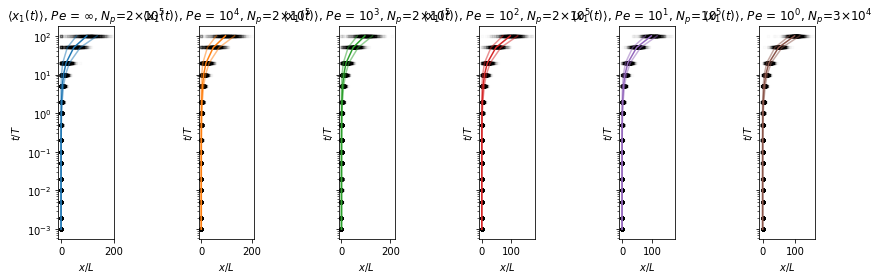

In [21]:
#####Plot of mean position for $x_1$ and total traveled distance#####
fig, axs = plt.subplots(1,len(PECLET), figsize = (12,4), sharey = True)
D_VALUES = [0]
Ntraj = 1000
d_ = 0
nbins_ = 40
c_ = 0
for i in range(len(PECLET)) :
    l_ = 0
    ax = axs[c_]
    for (d_,lst_) in zip(D_VALUES,['-']) :
        Pe_ = PECLET[i]; clr = color_cycle[i]
        TIME_= np.array([tt_ for tt_ in dataDNS[Pe_]])
        PDF_ = [Extract_pdf(dataDNS[Pe_][t_][:,d_], nbins_) for t_ in dataDNS[Pe_]]
        MEAN_= np.array([Return_mean(pdf_) for pdf_ in PDF_])
        STD_ = np.array([Return_std(pdf_) for pdf_ in PDF_])
        N_P_ = len(dataDNS[Pe_][t_][:,0])+1
        for n_ in range(Ntraj) :
            ax.plot([dataDNS[Pe_][t_][n_,d_] for t_ in dataDNS[Pe_]], TIME_, '.k', alpha=0.01)
        ax.plot(MEAN_,      TIME_, linestyle = lst_, color = clr)
        ax.plot(MEAN_+STD_, TIME_, linestyle = lst_, color = clr, alpha = 0.5)
        ax.plot(MEAN_-STD_, TIME_, linestyle = lst_, color = clr, alpha = 0.5)
    ax.set_title(r'$\langle$'+D_DICT[d_]+r'$\rangle$, '+'$Pe$ = '+v_to_pow(Pe_) + ', $N_p$='+v_to_pow(N_P_))
    ax.set_xlabel('$x/L$')
    ax.set_ylabel('$t/T$')
    #ax.set_xscale('log')
    ax.set_yscale('log')
    c_ += 1
plt.tight_layout()
plt.savefig(FDIR+'plume_mean_x1_l'+extension)

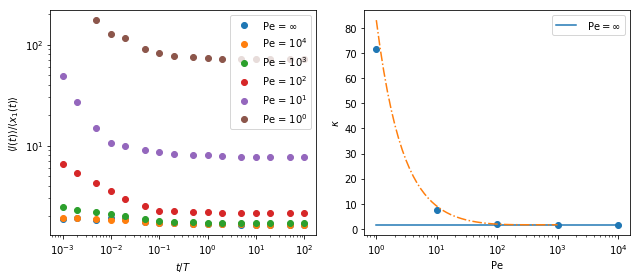

In [31]:
#####Retrieving tortuosity from mean l(t) and x1(t)#####
KAPPA_END = {}
fig, axs = plt.subplots(1,2, figsize=(9,4))

ax = axs[0]
ci_ = 0
for Pe_ in PECLET :
    clr_ = color_cycle[ci_]
    TIME_        = np.array([tt_ for tt_ in dataDNS[Pe_]])
    PDF_x1       = [Extract_pdf(dataDNS[Pe_][t_][:,0], nbins_) for t_ in dataDNS[Pe_]]
    MEAN_x1      = [Return_mean(pdf_) for pdf_ in PDF_x1]
    
    PDF_l        = [Extract_pdf(dataDNS[Pe_][t_][:,3], nbins_) for t_ in dataDNS[Pe_]]
    MEAN_l       = [Return_mean(pdf_) for pdf_ in PDF_l]
    KAPPA        = [ml_ / mx_ for ml_, mx_ in zip(MEAN_l, MEAN_x1)]
    x_           = TIME_
    y_           = KAPPA
    ax.loglog(x_, y_,'o', label = 'Pe = '+v_to_pow(Pe_), color = clr_)
    
    kappa_end = (KAPPA[-1])
    y_ = [kappa_end for xx_ in x_]
    #ax.plot(x_, y_,'--', alpha = 0.5, label = '$\kappa =$'+v_to_d(kappa_end), color = clr_)
    KAPPA_END[Pe_] = kappa_end  
    ci_ += 1
ax.set_xlabel(r'$t/T$')
ax.set_ylabel(r'$\langle l(t)\rangle / \langle x_1(t)\rangle$')
ax.legend();

ax = axs[1]
PP_ = np.array([Pe_ for Pe_ in PECLET if Pe_ > 0])
ax.semilogx(PP_, [KAPPA_END[Pe_] for Pe_ in PP_], 'o', color = color_cycle[0])
asymp_ = [KAPPA_END[0] for Pe_ in PP_]
ax.plot(PP_, asymp_, '-', color = color_cycle[0], label = r' Pe$= \infty$')

PeM_ = np.logspace(0,3)
ax.semilogx(PeM_,KAPPA_END[0]/(1-np.exp(-0.02*PeM_)),'-.', color = color_cycle[1])
ax.set_xlabel('Pe')
ax.set_ylabel(r'$\kappa$')
ax.legend()
plt.tight_layout()
plt.savefig(FDIR+'plume_tortuosity'+extension)

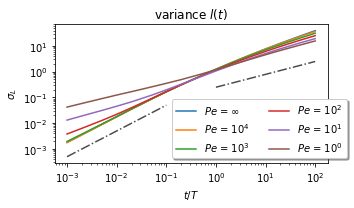

In [89]:
#####Plot of variance#####
fig, ax = plt.subplots(1,1, figsize = (5,3))
d_ = 0
nbins_ = 100
ci_ = 0
for d_ in [0] :
    #ax = axs[ci_]
    for Pe_ in PECLET :
            PDF_ = [Extract_pdf(dataDNS[Pe_][t_][:,d_], nbins_) for t_ in dataDNS[Pe_]]
            STD_ = [Return_std(pdf_) for pdf_ in PDF_]    
            N_P_ = len(dataDNS[Pe_][t_][:,0])
            ax.loglog([tt_ for tt_ in dataDNS[Pe_]],STD_, '-', label = '$Pe$ = '+v_to_pow(Pe_))
    ax.set_xlabel('$t/T$')
    ax.set_ylabel('$\sigma_L$')
    ci_ += 1
xlog1 = np.logspace(-3,-1,20)
ax.plot(xlog1, 0.5*xlog1, 'k-.', alpha = 0.7)

xlog1 = np.logspace(0,2,20)
ax.plot(xlog1, 0.25*xlog1**(0.5), 'k-.', alpha = 0.7)
ax.set_title('variance $l(t)$')
ax.legend(loc='upper center', bbox_to_anchor=(0.75, 0.5), shadow=True, ncol=2)
plt.tight_layout()
plt.savefig(FDIR+'plume_variance_x1_x2.pdf')
plt.savefig(FDIR+'plume_variance_x1_x2.png')

Possible thumb rules : 
$$ \lim_{Pe\rightarrow \infty} \sigma \approx \mu $$
$$ \lim_{Pe\rightarrow 0} \sigma \approx \textrm{const} $$

In [24]:
#####Counting the number of particles with negative position#####
def count_backflow (snapshot, greater, L) :
    x_ = snapshot[:,0]
    N_tot  = len(x_)
    if greater :
        N_back = np.sum(x_ > L)
    else :
        N_back = np.sum(x_ < L)
    return 1.0*N_back/N_tot

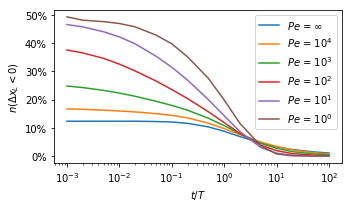

In [45]:
#####Plot of backflow#####
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(1,1, figsize = (5,3))

for Pe_ in PECLET :
    x_    = [tt_ for tt_ in dataDNS[Pe_]]
    y_    = [count_backflow(dataDNS[Pe_][t_], False, 0.0) for t_ in x_]
    N_P_  = len(dataDNS[Pe_][t_][:,0])
    ax.semilogx(x_, y_, '-', label = '$Pe$ = '+v_to_pow(Pe_))
ax.set_xlabel('$t/T$')
ax.set_ylabel('$n(\Delta x_L<0)$')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend()
plt.tight_layout()
plt.savefig(FDIR+'plume_backflow.pdf')
plt.savefig(FDIR+'plume_backflow.png')

## Markov model 

In [26]:
#####Model parameter set#####
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'L0'    :  3.0,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  22.6,     #Pore length ratio [-]
'phi'   :  0.22,     #Porosity [%]
'kappa' :  1.65,     #Tortuosity
'lmbd/L':  8.32,     #Correlation length [-]
#Theta angle model
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
'rdp'   :  0.0, #Random direction probability
#Beta angle model
'taub'  :  0.13,
'bb'    :  1.9,
#Log velocity magnitude model
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5,
#Diffusion model 
'a'     : 1.0 #molecular diffusion sensitivity
}

In [27]:
#####Tools for stochastic process#####
from scipy.stats import rv_continuous
#Diffusion function from DWM
def d(v,sample) :
    b = sample['b']
    c = sample['c']
    return c*np.exp(b*v)

#Drift function from DWM
def a(v,sample) :
    eps  = 0.1
    p_p1 = p_skew(v+eps,sample); p_m1 = p_skew(v-eps,sample);
    d_p1 = d(v+eps,sample);      d_m1 = d(v-eps,sample);
    d_   = d(v,sample);
    grad = (np.log(p_p1 * d_p1)-np.log(p_m1 * d_m1))/(2.0*eps)
    return d_/2.0 * grad

#Skew-normal PDF
def p_skew(v,sample = Bentheimer1000) :
    alpha = sample['alpha']
    mu    = sample['mu']
    sigma = sample['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p

class pskew_rv(rv_continuous):
    sample = {}
    def _pdf(self, x): return p_skew(x)       

def a_t (zt, yt, sample = Bentheimer1000) :
    omegat = sample['omegat']
    taut = sample['taut']
    return (omegat**2 * zt + yt / taut)   

def d_t (sample = Bentheimer1000) :
    bt   = sample['mut']
    taut = sample['taut']
    return bt**2 * 2.0/taut
    
def f_theta (zt, sample = Bentheimer1000) :
    omegat  = sample['omegat']
    sigmat  = sample['sigmat']
    epsilon = 1e-12
    return sigmat*np.sqrt(np.log((2.0+epsilon)**2) - 2.0*np.log((1-np.erf(omegat*zt/np.sqrt(2)))+epsilon))
    
#Log velocity magnitude model from Meyer and Bijeljic 2016
def Plume_process(param):
    sample = param['sample']
    if param['seed'] is not None : 
        rdm.seed(param['seed'])
    else :
        rdm.seed()
    
    dt    = param['dt']
    Tsnap = param['Tsnap']
    Np    = param['Np']
    Nsnap = len(Tsnap)
    delta = dt #Wiener process
    x_snapshots = {}
    l_snapshots = {}

    #Selecting a random initial velocity from skew normal pdf
    snd = pskew_rv(name='snd')
    snd.sample = Bentheimer1000
    v0      = snd.rvs(size=Np)
    ##
    
    #Initialization
    t_    = 0.0 #Time

    v_    = v0 #Log velocity magnitude
    
    theta_= np.zeros(Np) #Directional angle
    zt_   = np.zeros(Np, dtype=np.float64) #
    yt_   = np.zeros(Np)
    
    x_    = np.zeros(Np) #x1 position
    l_    = np.zeros(Np) #Traveled length
    
    c_    = 0
    
    ###Temporal loop
    while t_ <= Tsnap[-1] :
        ##Snapshot
        if (Tsnap[c_] - t_ < dt ) :
            x_snapshots[Tsnap[c_]] = [xx_ for xx_ in x_]
            l_snapshots[Tsnap[c_]] = [ll_ for ll_ in l_]
            c_ += 1        
        ##LVM process
        dW_ = rdm.normal(loc=0.0, scale=np.sqrt(dt), size=None)
        dv  = a(v_,sample)*dt + np.sqrt(d(v_,sample))*dW_
        v_ += dv
        ##Theta angle process
        dl_  = np.exp(v_) * dt
        dW_ = rdm.normal(loc=0.0, scale=np.sqrt(dl_), size=None)
        yt_ += -a_t(zt_, yt_, sample)*dl_ + np.sqrt(d_t(sample))*dW_
        zt_ += yt_ * dl_
        theta_ = f_theta(zt_, sample)
            
        ##Position update
        x_  += np.exp(v_) * np.cos(theta_) * dt
        l_  += np.exp(v_) * dt
        #Time update
        t_  += dt
    return x_snapshots, l_snapshots

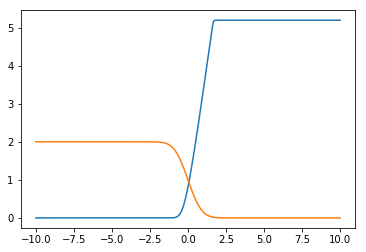

In [28]:
#####Note on the modification used to regularize f_theta function#####
x = np.linspace(-10,10,500)
x.astype(np.float64)
plt.plot(x, f_theta(x))
#plt.plot(x, np.sqrt(np.log((2.0+1e-12)**2) - 2.0*np.log((1-np.erf(x))+1e-12)))
plt.plot(x,1-np.erf(x))

Changed $\sqrt{\ln(4) - 2\ln(\textrm{erfc}(x))}$ to  $\sqrt{\ln((2+\epsilon)^2) - 2\ln(\textrm{erfc}(x) + \epsilon)}$ to avoid nan results

In [29]:
#####Auxiliary functions to save and load process results as dictionnaries#####
def Save_data(MP_dict, filename) :
    #Copy data into non np array dict for json formating
    No_np = {}
    for key in MP_dict : No_np[key] = [v for v in MP_dict[key]]
    with open(filename, 'w') as outfile:  
        json.dump(No_np, outfile)
    
def Load_data(filename, float_keys = False) :
    MP_dict = {}
    with open(filename, 'r') as outfile:  
        MP_dict = json.load(outfile)
    #Converting arrays in np array
    for key in MP_dict : MP_dict[key] = np.array(MP_dict[key])
    #Retrieving keys as float
    if float_keys :
        tmp = {}
        tmp = {float(key) : MP_dict[key] for key in MP_dict}
        return tmp
    return MP_dict

## Trying to account for Pe in process parameters

The model for directional angle should change with Peclet number

=> Tests of stochastic model with variation in $\mu_\theta$ (not convincing)

=> Tests of stochastic model with variation in $\sigma_\theta$ (not convincing)

=> Adding a probability $P(Pe;a)=(1+\tanh(-a\,\mathrm{Pe}))/2$ (where $a$ is the to move randomly at non dim. speed $v = \exp(1/\mathrm{Pe})$ for one timestep (It is maybe useful to set dt in order to reduce the traveled distance)

In [21]:
TEST_MODEL ={
'name'  :  'B1000_Pe',
'L0'    :  3.0,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  22.6,     #Pore length ratio [-]
'phi'   :  0.22,     #Porosity [%]
'kappa' :  1.65,     #Tortuosity
'lmbd/L':  8.32,     #Correlation length [-]
#Theta angle model
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
'rdp'   :  0.0, #Random direction probability
#Log velocity magnitude model
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5,
}

In [22]:
def rdp (Pe_, param) :
    Pe_ = np.array(Pe_)
    a = param['a']
    b = param['b']
    return (1+np.tanh(-a*(np.log10(Pe_/b))))/2

#Log velocity magnitude model from Meyer and Bijeljic 2016
def Diffusive_plume_process(param):
    sample = param['sample']
    if param['seed'] is not None : 
        rdm.seed(param['seed'])
    else :
        rdm.seed()
    
    Pe    = param['Pe']
    if Pe > 0 :
        u_diff = 1.0/Pe
    dt    = param['dt']
    Tsnap = param['Tsnap']
    Np    = param['Np']
    Nsnap = len(Tsnap)
    delta = dt #Wiener process
    x_snapshots = {}
    l_snapshots = {}

    #Selecting a random initial velocity from skew normal pdf
    snd = pskew_rv(name='snd')
    snd.sample = Bentheimer1000
    v0      = snd.rvs(size=Np)
    ##
    
    #Initialization
    t_    = 0.0 #Time

    v_    = v0 #Log velocity magnitude
    
    theta_= np.zeros(Np) #Directional angle
    zt_   = np.zeros(Np, dtype=np.float64) #
    yt_   = np.zeros(Np)
    
    x_    = np.zeros(Np) #x1 position
    l_    = np.zeros(Np) #Traveled length
    
    c_    = 0
    
    ###Temporal loop
    while t_ <= Tsnap[-1] :
        ##Snapshot
        if (Tsnap[c_] - t_ < dt ) :
            x_snapshots[Tsnap[c_]] = [xx_ for xx_ in x_]
            l_snapshots[Tsnap[c_]] = [ll_ for ll_ in l_]
            c_ += 1        
        ##LVM process
        dW_ = rdm.normal(loc=0.0, scale=np.sqrt(dt), size=None)
        dv  = a(v_,sample)*dt + np.sqrt(d(v_,sample))*dW_
        v_ += dv
        ##Theta angle process
        dl_  = np.exp(v_) * dt
        dW_ = rdm.normal(loc=0.0, scale=np.sqrt(dl_), size=None)
        yt_ += -a_t(zt_, yt_, sample)*dl_ + np.sqrt(d_t(sample))*dW_
        zt_ += yt_ * dl_
        theta_ = f_theta(zt_, sample)
            
        ##Position update
        x_  += np.exp(v_) * np.cos(theta_) * dt
        l_  += np.exp(v_) * dt
        #modeling diffusion with random direction probability (rdp)
        if rdm.random() < rdp(Pe,param) and Pe > 0 :
            #t_rdm  = np.pi/2.0*(1-2*rdm.random()) #Random direction between -pi/2 and pi/2
            t_rdm  = np.pi*(1-2*rdm.random(Np)) #Random direction between -pi and pi
            #v_ = np.log(u_diff) * (2.0 - 1.5 * rdm.random(Np))
            #x_ += u_diff * np.cos(t_rdm) * dt
            #l_ += u_diff * dt
            x_  += np.sqrt(6*dt/Pe) * np.cos(t_rdm)
            l_  +=np.sqrt(6*dt/Pe)
        #Time update
        t_  += dt
    return x_snapshots, l_snapshots

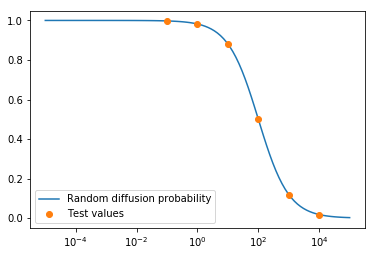

In [38]:
Xsnap = {}; Lsnap = {};
testname  = 'Pe'
TEST_PECLET= [0.0, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1]
Tsnap     = [0.01, 0.1, 1.0, 10.0, 100.0]
Nptot     = 1e5
Nthreads  = 200
Np_thread = int(Nptot/Nthreads)
a_ = 1.0
b_ = 100.0
MP_params = {'sample' : TEST_MODEL,
                'seed'   : None, 
                'dt'     : 1e-3, 
                'Tsnap'  : Tsnap, 
                'Np'     : Np_thread,
                'Pe'     : Pe_,
                'a'      : a_,
                'b'      : b_}
x_ = pow(10,np.linspace(-5,5,100))
plt.semilogx(x_, rdp(x_,MP_params), label = 'Random diffusion probability');
plt.semilogx(TEST_PECLET[1:], rdp(TEST_PECLET[1:],MP_params), 'o', label = 'Test values');
plt.ylim([-0.05,1.05]);
plt.legend();
plt.show();

In [45]:
RERUN  = True
NCORES = -1
for Pe_ in TEST_PECLET :
    MP_params['Pe'] = Pe_
    Xfname = 'D:/pdm_data/Processed_data/Markov_plume_X.dat'
    Lfname = 'D:/pdm_data/Processed_data/Markov_plume_L.dat'

    if os.path.isfile(Xfname) and os.path.isfile(Lfname) and not RERUN:
        Xsnap[Pe_] = Load_data(Xfname, True)
        Lsnap[Pe_] = Load_data(Lfname, True)
    elif RERUN :
        print('Running diffusive plume process for Pe = '+str(Pe_))
        start = time.time()
        results  = Parallel(n_jobs=NCORES)(delayed(Diffusive_plume_process)(MP_params) for n_ in range(Nthreads))
        stop = time.time()
        print('Time needed : ' + str(stop - start))
        Xsnap[Pe_] = {}; Lsnap[Pe_] = {}
        for tt_ in Tsnap :
            X_ = [];  L_ = []
            for n_ in range(Nthreads) :
                X_ += results[n_][0][tt_]
                L_ += results[n_][1][tt_]
            Xsnap[Pe_][tt_] = X_
            Lsnap[Pe_][tt_] = L_
        del results  
        Save_data(Xsnap, Xfname)
        Save_data(Lsnap, Lfname)
    else : print('Processed data not found.')

Running diffusive plume process for Pe = 0.0
Time needed : 832.633152961731
Running diffusive plume process for Pe = 10000.0
Time needed : 815.4064390659332
Running diffusive plume process for Pe = 1000.0
Time needed : 792.1135566234589
Running diffusive plume process for Pe = 100.0
Time needed : 792.3115994930267
Running diffusive plume process for Pe = 10.0
Time needed : 817.0095372200012
Running diffusive plume process for Pe = 1.0
Time needed : 823.5530467033386
Running diffusive plume process for Pe = 0.1
Time needed : 825.5088341236115


In [46]:
for key in Xsnap : print(key)

0.0
10000.0
1000.0
100.0
10.0
1.0
0.1


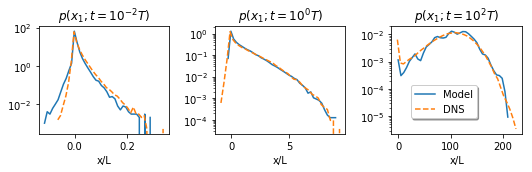

In [47]:
#####Comparison between Markov process and DNS data for Pe = Inf#####
T_PLOTS  = [0.01, 1.0, 100.0] #Tsnap[::-1]
PE_PLOTS = [0]
fig, axs = plt.subplots(len(PE_PLOTS),len(T_PLOTS), figsize = (2.5*len(T_PLOTS),2.5*len(PE_PLOTS)))
c_ = 0
for (Pe_, ci_) in zip(PE_PLOTS,['b','g']) :
    l_ = 0
    d_ = 0
    nbins_ = 40
    for t_ in T_PLOTS :
        if len(PE_PLOTS) == 1 : ax = axs[l_]
        elif len(T_PLOTS) == 1 : ax = axs[c_]
        else : ax = axs[l_,c_]
        ax.set_title(r'$p(x_'+str(d_+1)+';t=$'+v_to_pow(t_)+'$T)$')
        [x_, y_], N_P_ = Extract_pdf(Xsnap[Pe_][t_], nbins_, True)
        ax.semilogy(x_, y_,  '-', label = 'Model')
        
        [x_, y_], N_P_  = Extract_pdf(dataDNS[Pe_][t_][:,d_], nbins_, True)
        ax.semilogy(x_, y_, '--', label = 'DNS');
        ax.set_xlabel('x/L')
        l_ += 1
    ax.legend(loc='upper center', bbox_to_anchor=(0.4, 0.5), shadow=True, ncol=1);
    c_ += 1
plt.tight_layout()
plt.savefig(FDIR+'Plume_vs_markov_PeInf'+extension)

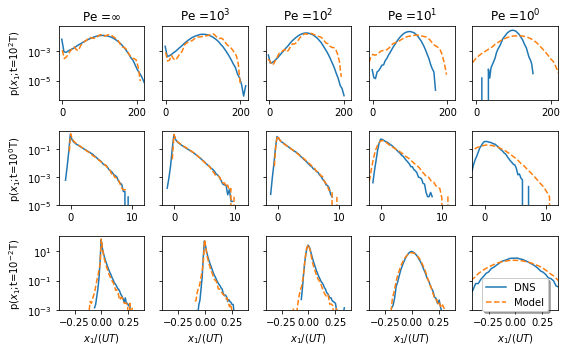

In [412]:
#####Comparison between Markov process and DNS data for Pe = Inf#####
T_PLOTS  = [100.0, 1.0, 0.01];
PECLET_PLOTS = [0, 1000, 100.0, 10.0, 1.0]
X_RANGE  = [[-10, 220],[-2, 12],[-0.4, 0.4]]
Y_RANGE  = [[5e-7, 5e-2],[1e-5, 2e0],[1e-3, 1e2]]
fig, axs = plt.subplots(len(T_PLOTS),len(PECLET_PLOTS), figsize = (8,5), sharey = False)
c_ = 0
for Pe_ in PECLET_PLOTS :
    l_ = 0
    d_ = 0
    nbins_ = 40
    for t_ in T_PLOTS :
        ax = axs[l_,c_]
        if l_ == 0 : ax.set_title(r'Pe ='+v_to_pow(Pe_))
        x_range = X_RANGE[l_]; y_range = Y_RANGE[l_]
        [x_, y_], N_P_  = Extract_pdf(dataDNS[Pe_][t_][:,0], nbins_, True)
        ax.semilogy(x_, y_, '-', color = color_cycle[0], label = 'DNS');
        [x_, y_], N_P_ = Extract_pdf(Xsnap[Pe_][t_], nbins_, True)
        ax.semilogy(x_, y_, '--', color = color_cycle[1], label = 'Model')
        if c_ == 0 : ax.set_ylabel(r'p($x_'+str(d_+1)+'$;t='+v_to_pow(t_)+'T)')
        else : ax.set_yticklabels('')
        if l_ == len(T_PLOTS)-1 : ax.set_xlabel(r'$x_1/(UT)$')
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        l_ += 1
    c_ += 1
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.5), shadow=True, ncol=1);    
plt.tight_layout()
plt.savefig(FDIR+'model_test'+extension)